In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt 

train = pd.read_csv('train.csv')
print(train.shape)
display(train.head())

CREATE_EEGS = False
TRAIN_MODEL = True

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [2]:
import tensorflow as tf 
tf.test.is_built_with_cuda()

2024-04-07 02:34:12.780344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 02:34:12.780432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 02:34:12.823632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-07 02:34:12.927575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 02:34:14.034654: W tensorflow/compiler/tf2

True

In [3]:
df = pd.read_parquet('./train_eegs/1000913311.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features')
print(list(FEATS))

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [4]:
print('We will use the following subset of raw EEG features:')
FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS,range(len(FEATS)))}
print( list(FEATS) )

We will use the following subset of raw EEG features:
['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']


In [5]:
def eeg_from_parquet(parquet_path, display=False):
    
    # EXTRACT MIDDLE 50 SECONDS
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((10_000,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
            
        data[:,j] = x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(10_000),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

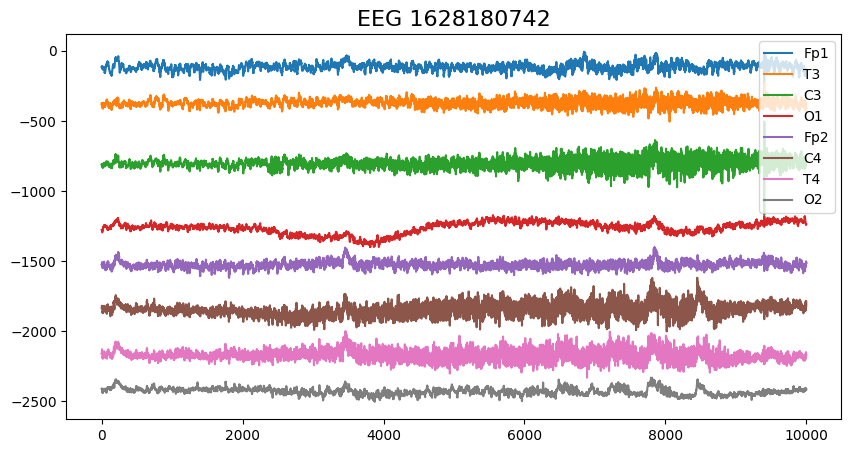

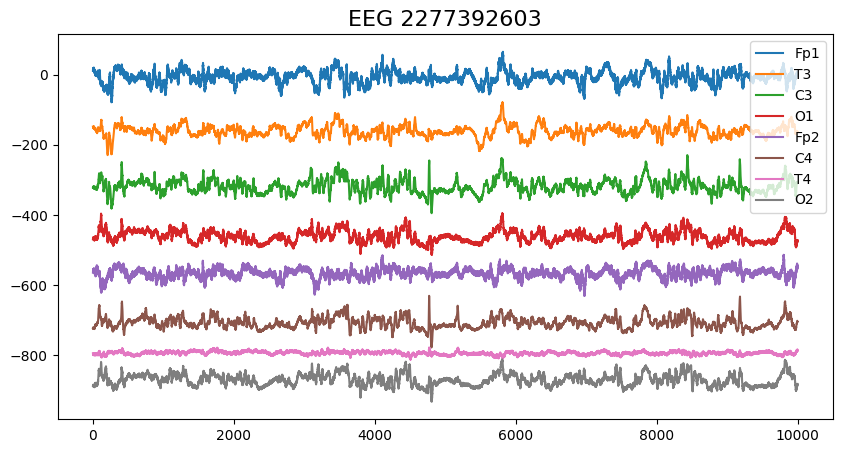

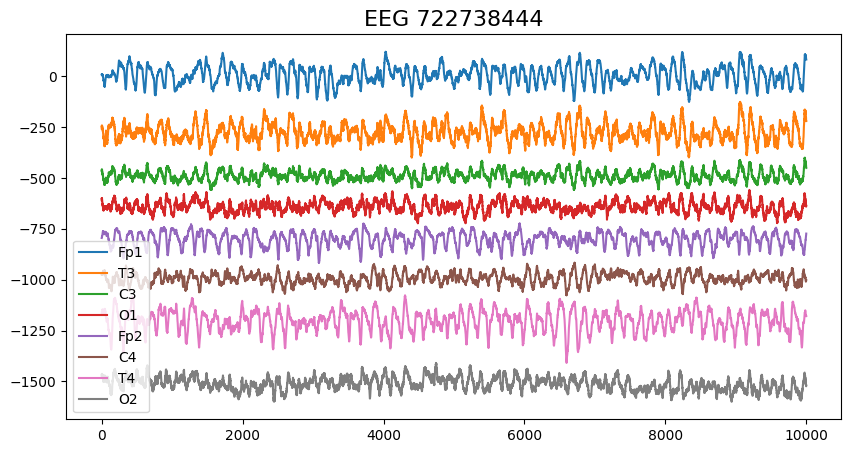

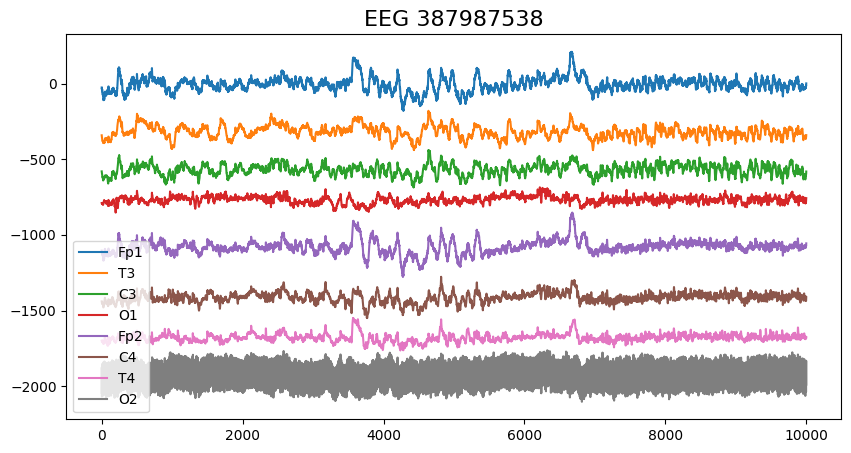

Reading 17089 eeg NumPys from disk.
CPU times: user 1.87 s, sys: 4.56 s, total: 6.42 s
Wall time: 8.1 s


In [6]:
%%time

all_eegs = {}
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
PATH = './train_eegs/'

for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='') 
    
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
    all_eegs[eeg_id] = data
    
    if i==DISPLAY:
        if CREATE_EEGS:
            print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
        else:
            print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
            break
            
if CREATE_EEGS: 
    np.save('eegs',all_eegs)
else:
    all_eegs = np.load('./eegs.npy',allow_pickle=True).item()

In [7]:
# LOAD TRAIN 
df = pd.read_csv('./train.csv')
TARGETS = df.columns[-6:]
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

train = df.groupby('eeg_id')[['patient_id']].agg('first')

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
train = train.loc[train.eeg_id.isin(EEG_IDS)]
print('Train Data with unique eeg_id shape:', train.shape )
train.head()

Train Data with unique eeg_id shape: (17089, 9)


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [8]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq=36, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

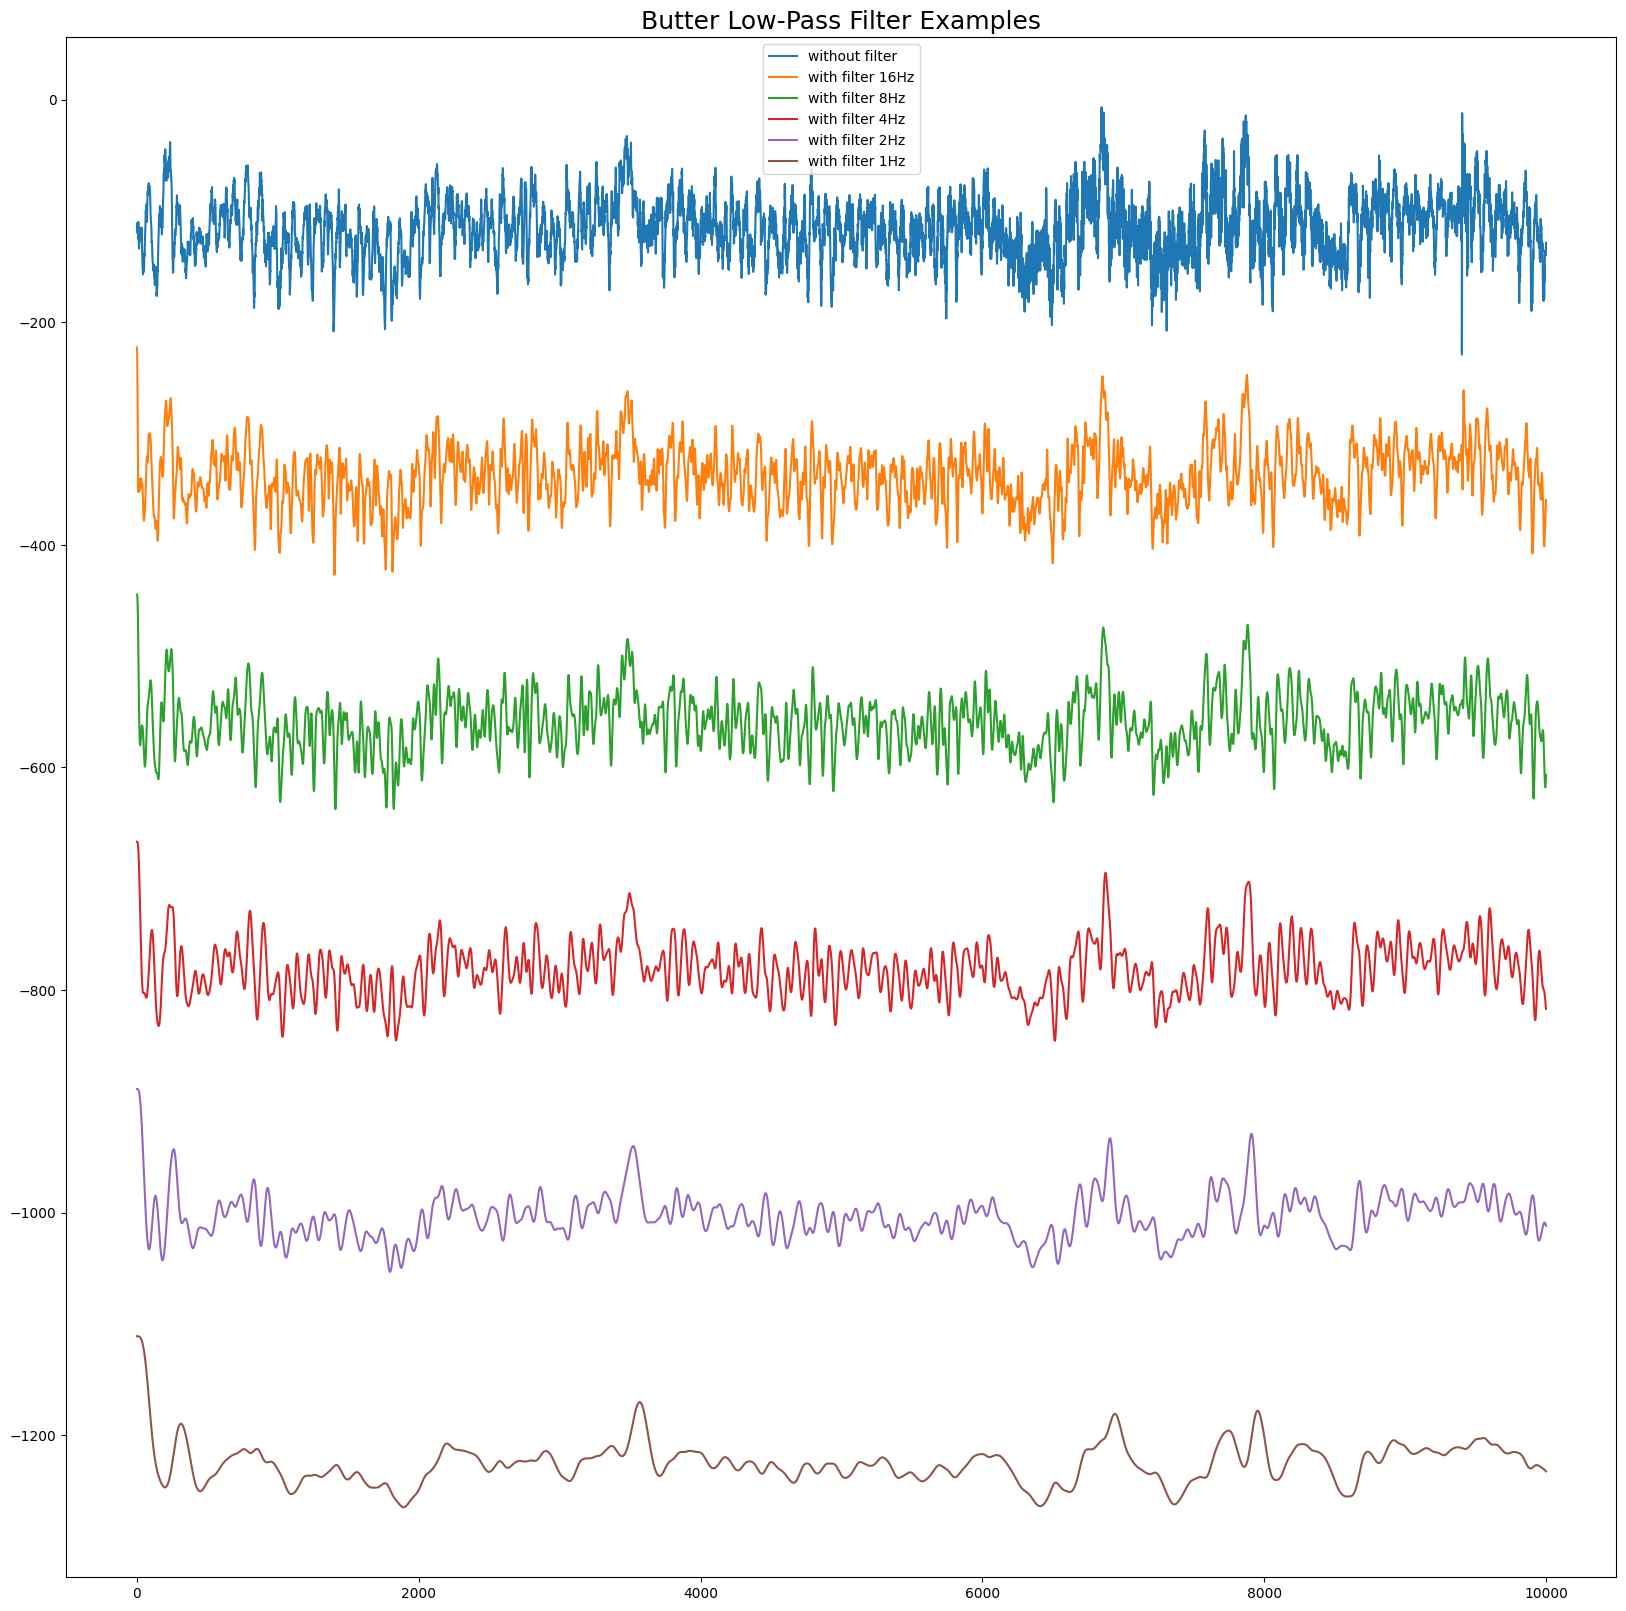

In [9]:
FREQS = [1,2,4,8,16][::-1]
x = [all_eegs[EEG_IDS[0]][:,0]]
for k in FREQS:
    x.append( butter_lowpass_filter(x[0], cutoff_freq=k) )

plt.figure(figsize=(20,20))
plt.plot(range(10_000),x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {FREQS[k-1]}Hz')
plt.legend()
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()


In [10]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, eegs=all_eegs, mode='train',
                 downsample=5): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.downsample = downsample
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X[:,::self.downsample,:], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        X = np.zeros((len(indexes),10_000,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        
        sample = np.zeros((10_000,X.shape[-1]))
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]      
            data = self.eegs[row.eeg_id]
            
            # FEATURE ENGINEER
            sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
            sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
            sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
            sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]
            
            sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
            sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]
            
            # STANDARDIZE
            sample = np.clip(sample,-1024,1024)
            sample = np.nan_to_num(sample, nan=0) / 32.0
            
            # BUTTER LOW-PASS FILTER
            sample = butter_lowpass_filter(sample)
            
            X[j,] = sample
            if self.mode!='test':
                y[j] = row[TARGETS]
            
        return X,y

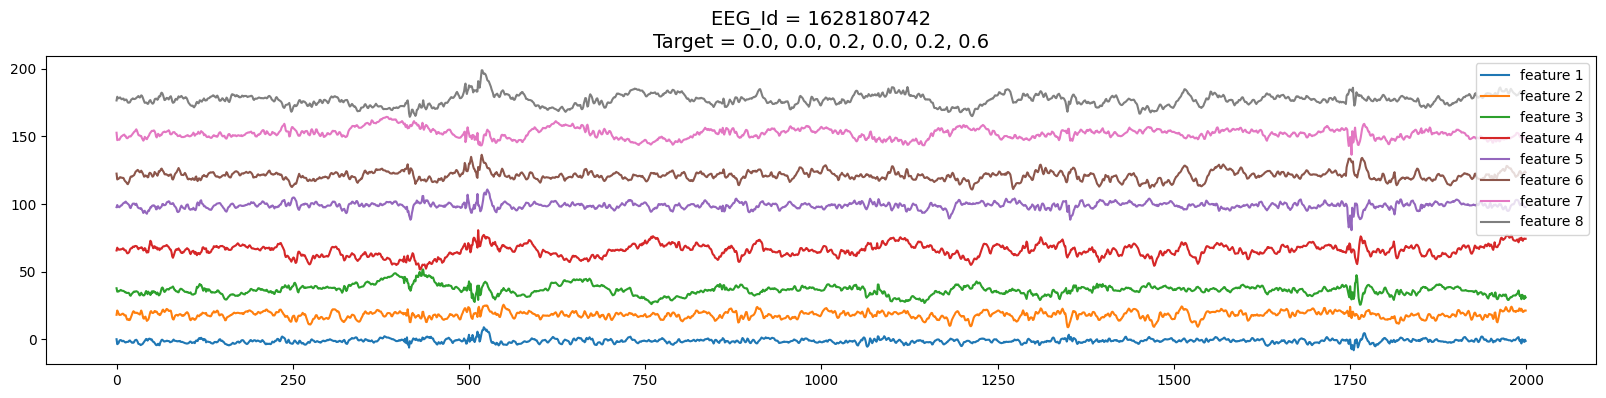

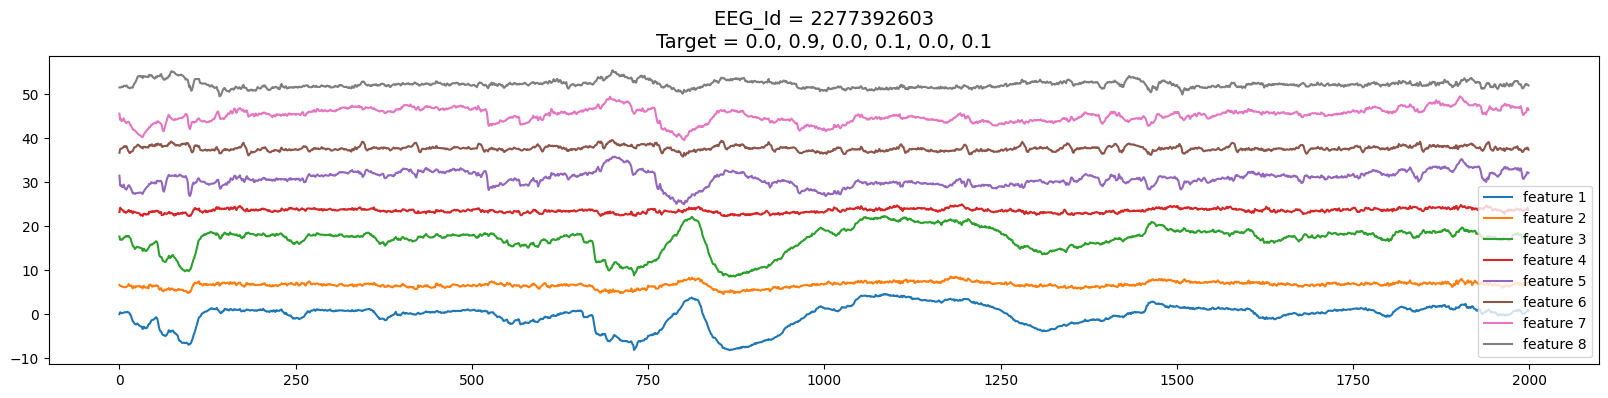

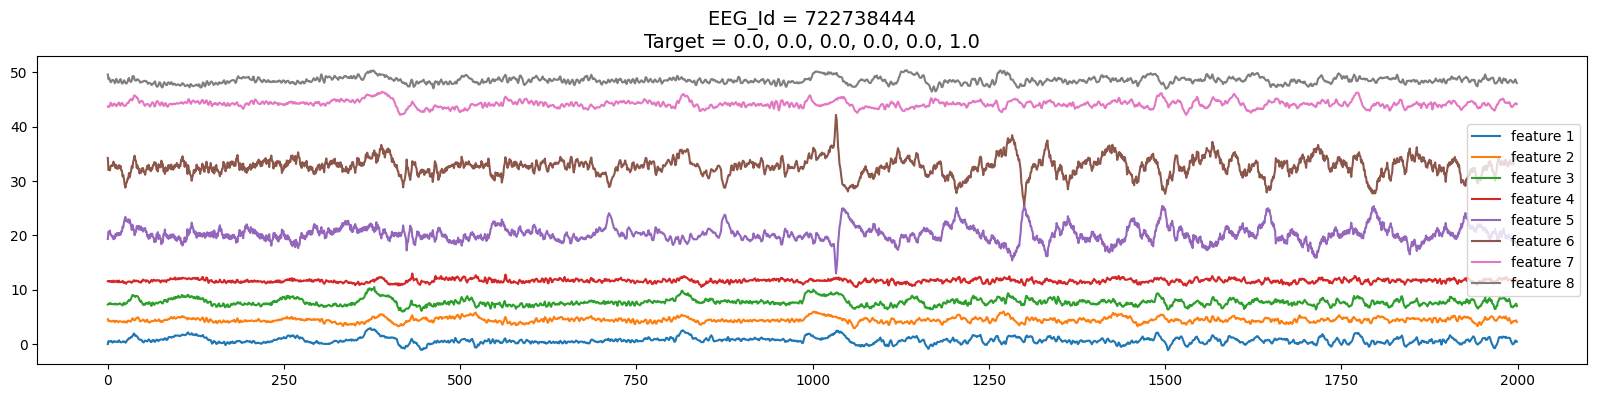

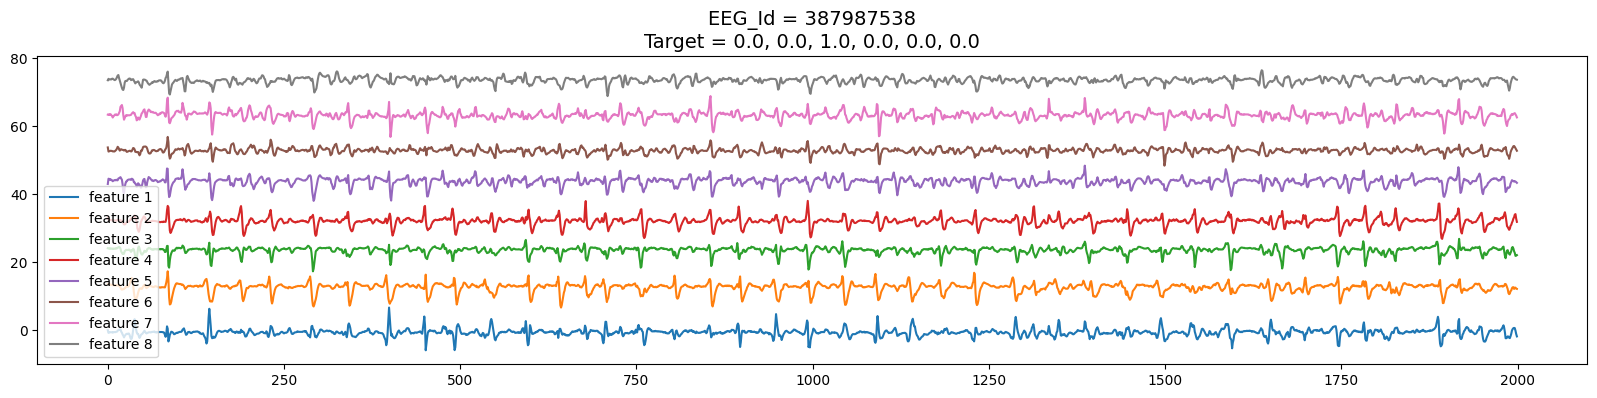

In [11]:
gen = DataGenerator(train, shuffle=False)

for x,y in gen:
    for k in range(4):
        plt.figure(figsize=(20,4))
        offset = 0
        for j in range(x.shape[-1]):
            if j!=0: offset -= x[k,:,j].min()
            plt.plot(range(2_000),x[k,:,j]+offset,label=f'feature {j+1}')
            offset += x[k,:,j].max()
        tt = f'{y[k][0]:0.1f}'
        for t in y[k][1:]:
            tt += f', {t:0.1f}'
        plt.title(f'EEG_Id = {EEG_IDS[k]}\nTarget = {tt}',size=14)
        plt.legend()
        plt.show()
    break

In [12]:
import os, random
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
print('TensorFlow version =',tf.__version__)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
SEED = 42
seed_everything(SEED)
    
# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

TensorFlow version = 2.15.0
Using 1 GPU


2024-04-07 02:34:25.576263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 02:34:25.719534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 02:34:25.719595: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 02:34:25.722658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 02:34:25.722714: I external/local_xla/xla/stream_executor

In [13]:
# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


In [14]:
# TRAIN SCHEDULE
def lrfn(epoch):
        return [1e-3,1e-3,1e-4,1e-4,1e-5][epoch]
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
EPOCHS = 5

In [15]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    print('x1',x.shape)
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)

    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

In [16]:


'''
class SamePadConv(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1, weight_norm=False, bias=True, stride=1):
        super(SamePadConv, self).__init__()
        self.receptive_field = (kernel_size - 1) * dilation + 1
        padding = self.receptive_field // 2
        self.remove = 1 if self.receptive_field % 2 == 0 else 0
        # TensorFlow does not directly support 'groups' in Conv1D; if groups is needed, a custom layer or workaround is required
        self.conv = tf.keras.layers.Conv1D(out_channels, kernel_size, strides=stride, padding='same', dilation_rate=dilation, use_bias=bias)

    def call(self, x):
        out = self.conv(x)
        if self.remove > 0:
            out = out[:, :, :-self.remove]
        return out

class BasicUnit(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, index, kernel_size):
        super(BasicUnit, self).__init__()
        last_idx = max(0, index - 1)
        base_reception = 2 * kernel_size - 1

        self.last_reception = base_reception**last_idx
        self.conv1 = SamePadConv(in_channels, out_channels, kernel_size, dilation=self.last_reception)
        self.conv2 = SamePadConv(out_channels, out_channels, kernel_size, dilation=self.last_reception)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = tf.nn.gelu(x)
        return x

class InceptionBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, index, residual, stride=1, hidden_channels=64, kernel_sizes=[3, 5], final=False):
        super(InceptionBlock, self).__init__()
        self.final = final
        self.conv_layers = [BasicUnit(in_channels, hidden_channels, index, ks) for ks in kernel_sizes]
        self.max_pool_layers = tf.keras.models.Sequential([
            tf.keras.layers.MaxPooling1D(pool_size=3, strides=1, padding='same'),
            tf.keras.layers.Activation('gelu'),
            tf.keras.layers.Conv1D(hidden_channels, 1)
        ])
        self.residual_fin = tf.keras.models.Sequential([SamePadConv(in_channels=hidden_channels, out_channels=hidden_channels,
                        kernel_size=1, stride=stride, weight_norm=False)])
        
        self.use_residual = residual and in_channels != out_channels
        if self.use_residual:
            self.residual = tf.keras.layers.Conv1D(out_channels, 1)

        self.aggregator = tf.keras.layers.Conv1D(out_channels, 3, padding='same')

    def call(self, x, res_prev=None):
        org_x = x
        if res_prev is None:
            res = [conv(x) for conv in self.conv_layers]
        else:
            res = [conv(x) + self.residual_fin(res_prev[i]) for i, conv in enumerate(self.conv_layers)]
        print('org',org_x.shape)
        res = [conv_layer(x) for conv_layer in self.conv_layers]
        print('x4', x.shape)
        res_mp = self.max_pool_layers(x)
        res.append(res_mp)
        x = tf.concat(res, axis=-1)
        print('11x', x.shape)
        x = self.aggregator(x)
        print('x', x.shape)
        if self.use_residual:
            x = x + self.residual(org_x)
        else:
            x = x + org_x
            print('last x', x.shape)
        return x, res[:-1]

class InceptionDilatedConvEncoder(tf.keras.Model):
    def __init__(self, in_channels, channels, kernel_sizes):
        super(InceptionDilatedConvEncoder, self).__init__()
        self.net = [InceptionBlock(channels[i-1] if i > 0 else in_channels, channels[i], i+1, 
                                   residual=True, hidden_channels=channels[i-1] // 4 if i > 0 else in_channels // 4, 
                                   final=(i == len(channels)-1)) for i in range(len(channels))]

    def call(self, x):
        res_prev = None
        for layer in self.net:
            x, res_prev = layer(x, res_prev)    
        return x
'''

"\nclass SamePadConv(tf.keras.layers.Layer):\n    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1, weight_norm=False, bias=True, stride=1):\n        super(SamePadConv, self).__init__()\n        self.receptive_field = (kernel_size - 1) * dilation + 1\n        padding = self.receptive_field // 2\n        self.remove = 1 if self.receptive_field % 2 == 0 else 0\n        # TensorFlow does not directly support 'groups' in Conv1D; if groups is needed, a custom layer or workaround is required\n        self.conv = tf.keras.layers.Conv1D(out_channels, kernel_size, strides=stride, padding='same', dilation_rate=dilation, use_bias=bias)\n\n    def call(self, x):\n        out = self.conv(x)\n        if self.remove > 0:\n            out = out[:, :, :-self.remove]\n        return out\n\nclass BasicUnit(tf.keras.layers.Layer):\n    def __init__(self, in_channels, out_channels, index, kernel_size):\n        super(BasicUnit, self).__init__()\n        last_idx = max(0, inde

In [17]:
# resnet model



'''
class Classifier_INCEPTION:

    def __init__(self, output_directory, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=6, kernel_size=41, nb_epochs=1500):

        self.output_directory = output_directory

        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs
'''
def inception_module(input_tensor, stride=1, activation='linear'):

    if int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(filters=4, kernel_size=1,
                                                padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    #kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [32 // (2 ** i) for i in range(3)]
    filter_size = [16, 32, 16]
    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(tf.keras.layers.Conv1D(filters=filter_size[i], kernel_size=kernel_size_s[i],
                                                strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = tf.keras.layers.Conv1D(filters=4, kernel_size=1,
                                    padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    return x

def shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                        padding='same', use_bias=False)(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x



In [18]:

def SamePadConv(x, out_channels, kernel_size, dilation=1, stride=1, bias=True):
    receptive_field = (kernel_size - 1) * dilation + 1
    remove = 1 if receptive_field % 2 == 0 else 0
    conv = tf.keras.layers.Conv1D(out_channels, kernel_size, strides=stride, padding='same', dilation_rate=dilation, use_bias=bias)(x)
    if remove > 0:
        conv = conv[:, :, :-remove]
    return conv

def BasicUnit(x, in_channels, out_channels, index, kernel_size):
    last_idx = max(0, index - 1)
    base_reception = 2 * kernel_size - 1
    last_reception = base_reception**last_idx
    x = SamePadConv(x, out_channels, kernel_size, dilation=last_reception)
    x = SamePadConv(x, out_channels, kernel_size, dilation=last_reception)
    x = tf.nn.gelu(x)
    return x

def InceptionBlock(x, in_channels, out_channels, index, residual=True, stride=1, hidden_channels=64, kernel_sizes=[3, 5]):
    conv_layers_outputs = [BasicUnit(x, in_channels, hidden_channels, index, ks) for ks in kernel_sizes]
    max_pool_layer = tf.keras.layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    max_pool_layer = tf.keras.layers.Conv1D(hidden_channels, 1)(max_pool_layer)
    combined = tf.keras.layers.Concatenate(axis=-1)(conv_layers_outputs + [max_pool_layer])
    aggregated = tf.keras.layers.Conv1D(out_channels, 3, padding='same')(combined)
    if residual:
        residual_connection = tf.keras.layers.Conv1D(out_channels, 1)(x)
        aggregated += residual_connection
    return aggregated




In [19]:
def build_model():
        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    inp2 = tf.keras.Input(shape=(2000, 1))
    dropout = 0.1
    '''
    ### InceptionTime
    x = inp
    input_res = inp
    for d in range(6):
        x = inception_module(x)
        if d % 3 == 2:
            x = shortcut_layer(input_res, x)
            input_res = x
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    model1 = tf.keras.Model(inputs=inp, outputs=x)
    '''
    input_shape = (None, 2000, 64)
    channels = [64] * 3 + [320]

    kernel_sizes=[2,5,8]
    x = tf.keras.layers.Dense(64)(inp2)
    for i, channel in enumerate(channels):
        x = InceptionBlock(x, channels[i-1] if i > 0 else input_shape[-1], 
                           channel, i+1, residual=True, hidden_channels=channel // 4 if i > 0 else input_shape[-1] // 4, 
                           kernel_sizes=kernel_sizes)
    x = tf.keras.layers.SpatialDropout1D(dropout)(x)
    x = tf.keras.layers.GRU(128, 
                            dropout = dropout, 
                            return_sequences = True, 
                            kernel_initializer = 'orthogonal')(x)
    model1 = tf.keras.Model(inputs=inp2, outputs=x)
    ############
    # FEATURE EXTRACTION SUB MODEL
    ### WaveNet
    '''
    x = wave_block(x, 8, 3, 12)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Dropout(dropout)(x)
    x = wave_block(x, 16, 3, 8)
    x = wave_block(x, 32, 3, 4)
    x = wave_block(x, 64, 3, 1)
    model1 = tf.keras.Model(inputs=inp2, outputs=x)
    '''
    ###########
    # LEFT TEMPORAL CHAIN
    x1 = model1(inp[:,:,0:1]) # shape - (none, 2000, 64)
    # inp[:,:,0:1].shape - (none, 2000, 1)
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model1(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])

    # LEFT PARASAGITTAL CHAIN
    x1 = model1(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model1(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model1(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model1(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model1(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model1(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    ## InceptionTime Multivariate
    # COMBINE CHAINS

    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    y = tf.keras.layers.Dense(64, activation='relu')(y)
    y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)

    return model

In [20]:
VERBOSE = 1
FOLDS_TO_TRAIN = 5
if not os.path.exists('WaveNet_Model'):
    os.makedirs('WaveNet_Model')

from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

all_oof = []; all_oof2 = []; all_true = []
gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    # TRAIN MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if TRAIN_MODEL:
        model.fit(train_gen, verbose=VERBOSE,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [LR])
        model.save_weights(f'./WaveNet_Model/WaveNet_fold{i}_inception36_wav.h5')
    else:
        model.load_weights(f'./WaveNet_Model/WaveNet_fold{i}_inception36_wav.h5')
    
    # WAVENET OOF
    oof = model.predict(valid_gen, verbose=VERBOSE)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    # TRAIN MEAN OOF
    y_train = train.iloc[train_index][TARGETS].values
    y_valid = train.iloc[valid_index][TARGETS].values
    oof = y_valid.copy()
    for j in range(6):
        oof[:,j] = y_train[:,j].mean()
    oof = oof / oof.sum(axis=1,keepdims=True)
    all_oof2.append(oof)
    
    del model, oof, y_train, y_valid
    gc.collect()
    
    if i==FOLDS_TO_TRAIN-1: break
    
all_oof = np.concatenate(all_oof)
all_oof2 = np.concatenate(all_oof2)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################


2024-04-07 02:34:28.637508: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-04-07 02:34:55.423376: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 5910/12809 nodes to float16 precision using 166 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 02:35:02.774686: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-07 02:35:04.198084: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-07 02:35:13.322324: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 02:35:13.322694: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 02:35:13.322905: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes 

428/428 [==============================] - ETA: 0s - loss: 0.9888

2024-04-07 02:45:17.200112: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6234 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 02:45:39.885235: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 02:45:40.045655: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 02:45:40.360684: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 02:45:40.423686: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

428/428 [==============================] - 734s 2s/step - loss: 0.9888 - val_loss: 1.0486 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
428/428 [==============================] - 796s 2s/step - loss: 0.7533 - val_loss: 0.8228 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
428/428 [==============================] - 762s 2s/step - loss: 0.6093 - val_loss: 0.7583 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
428/428 [==============================] - 763s 2s/step - loss: 0.5852 - val_loss: 0.7304 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
428/428 [==============================] - 762s 2s/step - loss: 0.5627 - val_loss: 0.7281 - lr: 1.0000e-05


2024-04-07 03:38:14.781034: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6203 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:38:16.853467: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:38:16.853893: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:38:16.856370: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:38:16.856498: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

54/54 [==============================] - 53s 835ms/step
#########################
### Fold 2
### train size 13671, valid size 3418
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-04-07 03:39:30.073665: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 5910/12809 nodes to float16 precision using 166 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:39:35.202687: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:39:35.213874: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:39:35.218904: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:39:35.222252: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Cons

428/428 [==============================] - ETA: 0s - loss: 0.9734

2024-04-07 03:51:45.196268: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6234 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:51:47.245657: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:51:47.251005: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:51:47.251399: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 03:51:47.252295: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

428/428 [==============================] - 806s 2s/step - loss: 0.9734 - val_loss: 0.9717 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
428/428 [==============================] - 771s 2s/step - loss: 0.7128 - val_loss: 0.8440 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
428/428 [==============================] - 769s 2s/step - loss: 0.5935 - val_loss: 0.6972 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
428/428 [==============================] - 769s 2s/step - loss: 0.5681 - val_loss: 0.6740 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
428/428 [==============================] - 769s 2s/step - loss: 0.5489 - val_loss: 0.6694 - lr: 1.0000e-05


2024-04-07 04:43:56.803910: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6203 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:43:58.839808: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:43:58.845399: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:43:58.847629: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:43:58.848780: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

54/54 [==============================] - 52s 835ms/step
#########################
### Fold 3
### train size 13671, valid size 3418
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-04-07 04:45:10.981314: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 5910/12809 nodes to float16 precision using 166 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:45:15.443159: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:45:15.447061: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:45:15.447638: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:45:15.450050: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Cons

428/428 [==============================] - ETA: 0s - loss: 0.9274

2024-04-07 04:57:25.123843: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6234 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:57:27.452303: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:57:27.455517: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:57:27.455624: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 04:57:27.456525: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

428/428 [==============================] - 803s 2s/step - loss: 0.9274 - val_loss: 0.9274 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
428/428 [==============================] - 767s 2s/step - loss: 0.6858 - val_loss: 0.8143 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
428/428 [==============================] - 766s 2s/step - loss: 0.5776 - val_loss: 0.6998 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
428/428 [==============================] - 767s 2s/step - loss: 0.5546 - val_loss: 0.6786 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
428/428 [==============================] - 766s 2s/step - loss: 0.5347 - val_loss: 0.6835 - lr: 1.0000e-05


2024-04-07 05:49:22.776396: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6203 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 05:49:24.807363: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 05:49:24.809404: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 05:49:24.812449: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 05:49:24.814150: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

54/54 [==============================] - 53s 849ms/step
#########################
### Fold 4
### train size 13671, valid size 3418
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-04-07 05:50:37.956586: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 5910/12809 nodes to float16 precision using 166 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 05:50:42.980725: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 05:50:42.981910: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 05:50:42.982269: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 05:50:42.984976: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Cons

428/428 [==============================] - ETA: 0s - loss: 0.9660

2024-04-07 06:02:54.002702: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6234 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:02:56.211755: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:02:56.218826: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:02:56.219952: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:02:56.220923: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

428/428 [==============================] - 807s 2s/step - loss: 0.9660 - val_loss: 0.9011 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
428/428 [==============================] - 767s 2s/step - loss: 0.7020 - val_loss: 0.7921 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
428/428 [==============================] - 766s 2s/step - loss: 0.5756 - val_loss: 0.7027 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
428/428 [==============================] - 767s 2s/step - loss: 0.5468 - val_loss: 0.7047 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
428/428 [==============================] - 767s 2s/step - loss: 0.5272 - val_loss: 0.6825 - lr: 1.0000e-05


2024-04-07 06:54:53.335606: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6203 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:54:55.244519: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:54:55.245992: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:54:55.247345: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:54:55.248972: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

54/54 [==============================] - 53s 847ms/step
#########################
### Fold 5
### train size 13672, valid size 3417
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-04-07 06:56:08.477598: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 5910/12809 nodes to float16 precision using 166 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:56:13.539855: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:56:13.541684: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:56:13.545644: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 06:56:13.548817: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 29/66 nodes to float16 precision using 5 cast(s) to float16 (excluding Cons

428/428 [==============================] - ETA: 0s - loss: 0.9699

2024-04-07 07:09:09.740770: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6234 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 07:09:11.602377: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 07:09:11.603054: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 07:09:11.603091: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 07:09:11.604176: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

428/428 [==============================] - 865s 2s/step - loss: 0.9699 - val_loss: 0.8321 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
428/428 [==============================] - 765s 2s/step - loss: 0.7189 - val_loss: 0.7824 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
428/428 [==============================] - 766s 2s/step - loss: 0.5860 - val_loss: 0.6852 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
428/428 [==============================] - 766s 2s/step - loss: 0.5642 - val_loss: 0.6880 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
428/428 [==============================] - 765s 2s/step - loss: 0.5462 - val_loss: 0.6836 - lr: 1.0000e-05


2024-04-07 08:01:17.811253: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 2605/6203 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 08:01:19.898344: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 08:01:19.898418: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 08:01:19.899210: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const and Variable casts)
2024-04-07 08:01:19.899350: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 27/39 nodes to float16 precision using 5 cast(s) to float16 (excluding Const a

54/54 [==============================] - 53s 851ms/step


In [21]:
import sys
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

CV Score with WaveNet Raw EEG = 0.6894425282865199


In [22]:
oof = pd.DataFrame(all_oof2.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with Train Means =',cv)

CV Score with Train Means = 1.2641160568651757
